<a href="https://colab.research.google.com/github/sajidmahmud69/Machine-Learning/blob/main/arbitrary_styles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Import required libraries

In [ ]:
# built in libraries
import functools
import os

# thrid party libraries
from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print ("TF Version: ", tf.__version__)
print ("TF_Hub Version: ", hub.__version__)
print ("Eager Mode Enabled: ", tf.executing_eagerly())
print ("GPU is ", "available" if tf.config.list_physical_devices('GPU') else "not available")

TF Version:  2.4.0
TF_Hub Version:  0.11.0
Eager Mode Enabled:  True
GPU is  available


# Define image loading and visualization function

In [ ]:
def crop_center (img):
  """Returns a cropped square image"""
  shape = img.shape
  new_shape = min (shape[1], shape[2])
  offset_y = max (shape[1] - shape[2], 0) // 2
  offset_x = max (shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box (img, offset_y, offset_x, new_shape, new_shape)

  return image

@functools.lru_cache (maxsize=None)
def load_image (image_url, image_size = (256, 256), preserve_aspect_ration = True):
  """Loads and preprocess images"""

  # Cache image files locally
  # Download the file in directory ~/.keras/datasets/<the name you are giving it> i.e 640px Golden_Gate_Bridge...
  image_path = tf.keras.utils.get_file (os.path.basename(image_url)[-128:], image_url) # 1st param is the path where to save it and under what name and 2nd param is the url of the file

  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1]
  img = plt.imread (image_path).astype(np.float32)[np.newaxis, ...] # plt.imread (<path to image file>) returns numpy array
                                                                    # astype (np.float32) change data type to float 32
                                                                    # np.newaxis add one more dimension to the existing shape
                                                                    # ... spread operator -> means keep the dimension same after the comma
                                                                    # ex: if shape is (1,3) (np.newaxis, ...) will make it (1, 1, 3)
                                                                    # ex: if shape is (3,) (np.newaxis) will make it (1,3)
  # divide every number by 255 to squeeze it between 0 and 1
  if img.max() > 1.0:
    img = img / 255
  if len (img.shape) == 3:
    img = tf.stack ([img, img, img], axis = 1)      # tf.stack example: takes in a numpy array or a tensor
                                                    # x = tf.constant ([1,4])
                                                    # y = tf.constant ([2,5])
                                                    # z = tf.constant ([3,6])
                                                    # tf.stack ([x,y,z])
                                                    # >> tensor shape = (3,2)
                                                    # >> array ([[1,4],
                                                    #            [2,5],
                                                    #            [3,6]])

                                                    # tf.stack ([x,y,z], axis = 1)
                                                    # >> tensor shape = (2,3)
                                                    # >> array ([[1,2,3], 
                                                    #            [4,5,6]])
  img = crop_center (img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)

  return img

def show_n (images, titles = ('',)):
  n = len (images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize = (w * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range (n):
    plt.subplot (gs[i])
    plt.imshow(images[i][0], aspect= 'equal')
    plt.axis ('off')
    plt.title (titles[i] if len (titles) > i else '')
  plt.show()

# Let's get some pictures to play around with

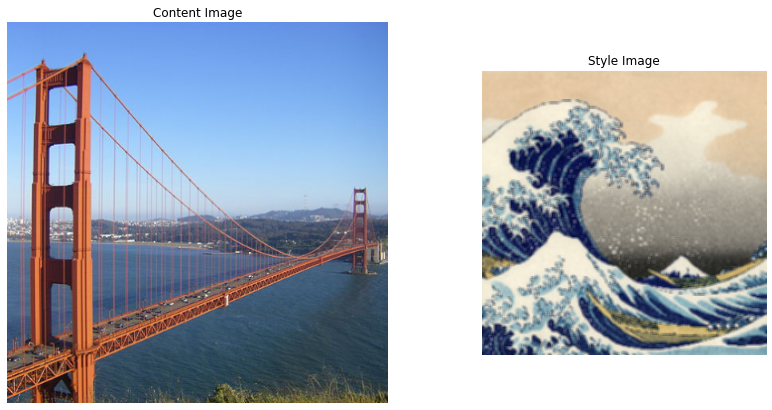

In [ ]:
content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'
output_image_size = 384

# The content image can be arbitrary
content_img_size = (output_image_size, output_image_size)

# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as well
# but the results will vary)
style_img_size = (256, 256) # Recommended to keep it at 256

content_image = load_image (content_image_url, content_img_size)
style_image = load_image (style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize= [3,3], strides= [1,1], padding= 'SAME')
show_n ([content_image, style_image], ['Content Image', 'Style Image'])

# Improt TF-Hub module

In [ ]:
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load (hub_handle)

The signature of this hub module for image stylization is 

In [ ]:
outputs = hub_module(content_image, style_image)
stylized_image = outputs [0]

Where **content_image**, **style_image**, and **stylized_image** are expected to be 4-D Tensors with shapes **[batch_size, image_height, image_width, 3]**

In the current example there is only one example and therefore the batch dimension is 1, but one can use the same module to process more inmages at the same time

The input and output values of the image should be in the range [0,1]

The shapes of content and style image don't have to match. Output image shape is the same as the content image shape.


# Demonstrate the image stylization 

In [ ]:
outputs = hub_module (tf.constant (content_image), tf.constant (style_image))
stylized_image = outputs [0]

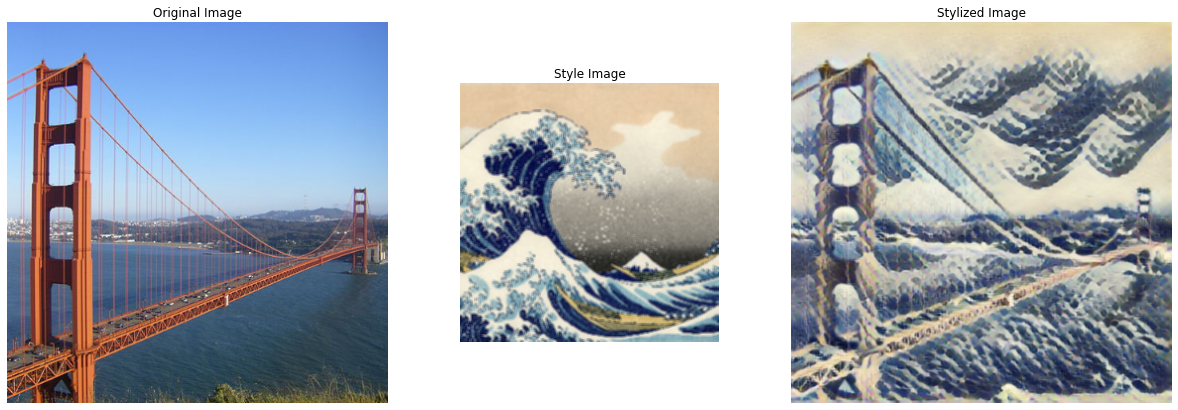

In [ ]:
# Visualize input images and the generated stylized image
show_n ([content_image, style_image, stylized_image], titles= ['Original Image', 'Style Image', 'Stylized Image'])

# Some More Images for Practices

24576/20834 [===================================] - 0s 0us/step


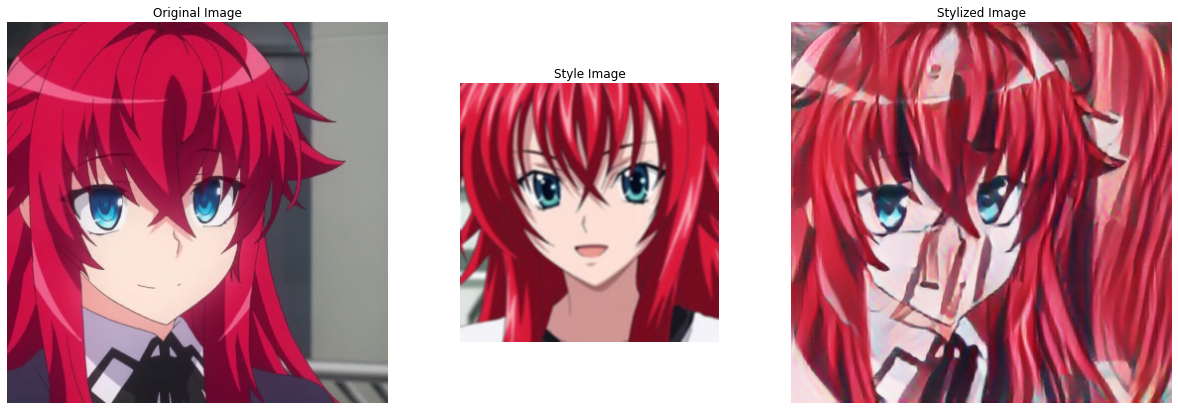

In [ ]:
# content_image_url = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxITEhUTExMWFRUXGR0XGBgYFxgaIBsgHxodHR4gHRoYHiggHx0lHRgfIjEhJikrLi4uGB8zODMtNygtLisBCgoKBQUFDgUFDisZExkrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrK//AABEIAOEA4QMBIgACEQEDEQH/xAAcAAACAwEBAQEAAAAAAAAAAAAFBgAEBwMCAQj/xABVEAABAgMEBAkGCQkGBAYDAAABAgMABBEFEiExBkFRcQcTIjJhgZGhsRQzQlJywSNic4KSorLR8BUkNDVTs7TS4RYXJUNj8YOUwsRkk6PD0+IIVFX/xAAUAQEAAAAAAAAAAAAAAAAAAAAA/8QAFBEBAAAAAAAAAAAAAAAAAAAAAP/aAAwDAQACEQMRAD8AR1posnUrH52um8Y+7XH1xwApSfSr3Df+O+K9kzAdZSCeWnVrwyO6KlrzV11knChJPXgYDb+CxbUzKqaXeK2FBPnF8w4owrTAAj5sNg0WZrW8s9Y94MYloNpUJKe5WDbibq6AnA80gDO6rVhgoxszdrzJoQgEbfJ3wewV8YAxJWa21zRjtNDFlFdZGeFNn3wCFovayobpN4d5VEmp5hdOMafURhzFo7qiAOs1FbxBxwoKYdp7YVrVc8ptJqVzaYR5S6NqiSloHaAQpXUIuM2lLhHFJaWEnC6SjGu9dYF6KpH5TtGgoEJl209CQ2SB3wDomPUDnbJQo4uPdTzg7gqODlgMnnLeO+YdHgqA82og3sppQIyaUAB9YGBbNmPOKoePbQa4rUK9gdWT2CDjDbLCClC0p6VuKXjvWqvfAyYtVSAVLnpQJGfJp9Yumm+kAE0fl+LmrVQCVUQ3ic/NKzhOsawpaas6VS82CeKTRScFDpBGPjnBGS0vpNz7qZZ15t9KEpWxRaOSgpwUu5eFT6IMCNHLVPkjEswKzCWwlYUkgM6ipYIrrwTmSd5AU3nJqRmEKcWqbl2kGh/zG0uFI5QwvYt6u6K2l9osvutOMrDiVN4kaqKNAdhx17Ia0aPMEVdTxzhHKccxKq9FaAZ8kYYwNmNA5QqvN32a5hCjQ9RrTq6YBJLqRmodoj2U/jONHlNHZRtJSlhFCMai8TqxKsa5QCmNDWUrvcY6lo4UCgbh21UCSnrwwgFUR4eYSsUUARDVOaDqzZmD7LiAR9JNCOusA7QsuYl/PN8n10EqT16x1iAW5uwknFtVOg49kBJqWUg0UKQ2TM4hKbxUO413Qqz02XFVOA1DZAfJWccbNW1qQdqVEeENNlcJE8zQKWl5OxwY/STQwpNsKVklR3AmLTVjTKubLvK3NrPgIDY9HeERmYBvtraKQCogX0jVUkcoDqpDPL2pLuC8h5tQ6Fp+/wDHdGKaO2LabLgW1IzCsCCOKWKg707uyNAs6wSu6t2xJlTgFKKLV0ZeupOzWnCAO2a8Zh7j0ikugFDRIIvqJF5YHqYXQddTqxjjpjbPk0ubp+FdqhroNMVbkj8bCITaZ5lmFOwLmGk0+gFQp2/weW1OulxwS7YpdQnjSbg10ITiTrMBnlxP7Y/SP80SG7+4u0v2sv8ATX/LH2ARbHfKQSgVWnMesjX1g4jdFi2mA8jjm1VoMU+PXDpIcClqBQUHJdv/AIi1eCIOyfAzNhSlGbl03ucEtLUOwqEBibcwoKBqcMMTq2bo2zQDSUPoRLuOrCrvwRo+6VgZpoh1ISpOymIodsemuANJNVzxxx5LQ96oMWZwJsMlJE9NgpNQWyhFDtHJNIA8izicOKcX0mXSO912CErYdRykhre1Lk9ySO+KX93rZ85P2i57U0R+7SmPY4OJDNQfX7cy+ruK6QFw2Y2jHyu503ZYf+3CVJWiyxbE0hyeKUPMtuB2+2KqTVJBITdrTYIbk8HVl65NtXtVV9omFHhC0XlZJcpPMyzSGmHQl9CWxQoXheUmmNCYA65pLZKOfapVt/OVeDdIoTOkNhOYqW4/sqiad7qGHliQlkpvJaZSml6oQgClK1rTLpjP7b0qXNqUxIHipcYOTSQAVbUsfz5YGkBR/tNJm81IpcccGF0yzbSUn463GiQBspXZHNNll2hnHfKFAkhF0JaRso2kAKptVju1eJUISkMywABrVedBrUSecpRyrgc8oJMMBIATl0mp3knEnpgONozJbbHFpBWohDacACTllqAqo9CemOUpKJaAAN9Ti+Ws5rIBJJ6OTQDUMI4zyqqWvWkcUjD0lkBRx3gdR2xZNAtpIOASvuup/wCqAIViKijZ7lVOn490fNSB4kxcCu7AwHCQmLwUDS8hRQum0CtdxBB649qcBUUEVwyORBND4wOS6BNYZOpKCPjox7Shf1RHy0JsomWQTQLJGWeBqM9t05aoC7JKuktmvJpdJ9JNMOsc07gdcWyMIqtELorWkke4g+Me5oqAqgVUMabeiAXrR0PZ40vtJCVnNBQhST0hCwRXPZXaM4Y7JtGXYoJqz5cIw+HZZFB7bVCUbwVDdHmVfS4hK0moIrjgekHYQcKdEdHFACpyGfRAaFJMMFIW0hq6RUFCU0I6CBFxIGqkZZKTT8nedlU8Yg4rliaJV0tn0FdGR2VNYLWTpVac02HZeQl7hwBXNYgjMKSlFQobKwD9EpCaF28fRs1G8zC/5Y9fk+21ZzkmjoTLLP2nIBwj5CgrR21Fc61in5OWaH2qx5Ohk0rzlrzp9jiW/BEA5RIS/wCwKv8A+taf/MI/+OJAOdIhjObGmphMta7a5lx5UspaW3FkXgOICvRAGZjtYOgUq/LMOvuTTqltoWq9NP0qUgnAKFIB9W+lOakjeQPGKb1tSyedMMp3uIHvhfa4MbJSa+RpUfjuOr+2sxdb0DstNKSMvh/pJ8YDo9prZyOdOy4/4qfvim5wj2WMpttXs3lfZBgyzYEojmyzI3No+6Ljcqgc1CRuSBAKX95kgTRAmXPYlnlf9MVrQ0zZmGltfk6feQsFKh5PdqD0uKFIewKRnun9uLdWZBhRSKAzLifRScm0n11DPWEnpEAiWTbr04ymzVqUiXZvBRJo4+hKylCag0okABVDjqgnbs6lhtDSAEqdPFISkZDAGlMsMAdqhHSaspKkIDNG1teaIFQMKXSNaSMD25wGsR5U1PuOrTc8nQGwioNFnnKw1YYE7dWUAy2ZJ8WgA0KjiqncB0AYDdvj25NCqvVQMT1V7sI6Pu3EqURUJBPYKwJtI8XKmvOWUJVT1nVpSft90BwnnShtjMFS1OqGGptayPpFPZBFCLrjSdfFrr2t/dAfSh+kxKorneHUooTr9rfBObcpMI6h9ILHiEwHuwnbyV7eNcr9M+6Ptiv8YhS61CnHKbgopHcIHS8xxKZ8nANqU4NXOaSrxr/vFjQ8fmTG0oCjvOMBVtxZRMtEekUL3FKrijvKHR9CPOnKriGHa4tTDauo4Huj1pqCENrHorOzWhW0HWBHLhGxkXDsUgjtgDDTwTMrRXBxCXBlmDcOvZcMepC0LxKFUCgVADbcVRXZn86F+25/i3JFZNL6Sk47Qg+6PL06lqdfQdRbmE9FQG3B9Gh6iawB1pZamS3/AJbwK09CxzxuIINN8E3FgZ0pkYE6RqCEsu+o8jsWbh7b0E32wpJSdYp+PxsgK8i5dUpkitzFBzqk+9JqnqEfbPnfIZoTKcGHlJRMp1AnBDoGqijRXQa6ooTD54tExT4RklLgpjdrRzLoosYaoJzLSVpUhVFJWkgjaD/QwGqoyj1Cfwb2opyXUw4olyWVxJJzUkAFtR3pz6QYcICRIkeVDZAfYkVvJFftV933R8gEGT83pB8o5/DJhy0Q/QZX5Bv7AhMkuZpB8o5/DJhy0NP5hKfIN/YEAYiRIkBIkSKlqWg2w0p1w0SkVO09AGsnICAoaUWyJZqooXVcltO07fZSMT0CM3QA2n1nHFFSlHNa1c5SvxQBIAwpHS0bQW8+XXMFAUpWoaSTyW019I0qo68MqCKrRK5hWPJaTd+coXlYbQm79KAvtCmGzOF7RaVvsiYHJccWtwK10KzdCtqaAYH+sFbXmrku64PRQoj6J98eNHWQiXZQPRbT4QHydnbym2SKKW4KjUUp5SqE4UN2m3GBOkVoVblgceOmEFPspXUe6Pels1cK162pdxYzwUopSnI54HHPPbChpm+tlcm2VXgyhKwderPaeTnAM+lrlJ2Q9uh+kk+6DFpqo4raltLm8IcqdXTCpwhTKUPSrqT6QXUbARrGrCGubA8qbrk42tFabaKGO2iTABtNJgNeUHVMS10bLyFeN1zuEH9GBSTlx/pI+zC5phKl6QNQeMl1H6uBp0FBB7IP6KTCVSbBBGDaU9YFCIClwgOkSlf9RHjT3xw4S10kFDapA7/6R208Rel0IzvPNinzorcIjIcaQ1U4BbxA2IQRj0VUIBd0xfUZWzljMN3/AKqPx1x60yQrjlTYxCW2kqG0OIXnjF20pUGTUk48TIoVuK3AB9gxbXK8dZ06cyG2Kf8ADYQuv1z2QBG05suWXx1eVxSHetN1XiINImCHbpyUm8n3gdVD1mE4zFLEr/pXO1VINvFxyWQ42PhmgFJHrFIxTjqUnDrEAQULjxBFUPihFBS8BQg+0nwiWQ7yS2ec0ot41xA5px2pp2R8YfRNMBaSQlYqCMChQ8ClQ7oqtzNJgEihWOKcFDzkgqQdxReoegDVSAYdGZnibRbPozKCyr20VW2ewKT2Rp0YzbUyWmuOGBYcQ9XoQsFVN6QR1xsTTgUARkRXtgOkSJEgJEiRIDNZLm6Qe2v+GTDhoV+r5T5Bv7AhOkubpB7a/wCHEOGg/wCr5T5Bv7IgDcSPhgXaVvsMm6pV9zMNNgrcVubTVVOnLpgL83NIbSpa1BKUipJyAEZFpvpiCoKIN1OLDFOUScA44Mk1OVct5hscsydnl3pm7LMAgtsgha6+ssjkXtlLwG/IDppJMsvSsoym6CVTL6qlSl3KJRfWcTyjUbLmEAFkWyFJbUq8pI411W1assTqFDQagkR4sx2kut3W6ta6+0u6n6oTFeWmAGJmZr5wuLrXUlJbRjqwSI+tDi2JRquNWwcfVQVHPpEB803cuSLwGwJHWQnw8IJWUvADY23qPqwv8JDn5kobVp++Ctjui8Olho/aGG2AXdPXyETONKiXbH0nFH3R5tOz/Kpt5IFT5ACjXRXJIp3jripwgnB75Rkf+mswS0ZtVtM4lxdTek2wEpSVKJwqAkYnLVAAdKUJdkZSYTX9mrYCBsG0iCstpCVNSb6kkcW6GlqwpiKZ46q50ig/IvkzMkUllBCptpC0i8aHBNQaDA9ORgLYb1WnZdWCXU3myf2iMRTeOT1wGnWzdDgrQtTHIUo0olxPmySMKKBKcdiYCaLvlgPN3byWVFLzdKkJxotI17FJpqqNh6SrLc9IVKQHSgpKqYhadeFMTdB/BgJZk0sJbmxf45BLbwGbqBQEjDNOBPsk6jQGS25ALcluKeXdccCgL15ACEk3kjrGBOuBlry88rytZebWlpviFkoKSQ5dUQAMArm4+4QTQ0lDvlDKgpltou3SoAfCE1KTkOSgm6TTHDWY8WmlxcrLtpUpK5h++80oFCuUSoYEAhKUITyhgbo2wFWalJ5MhMuLLHFupDZAv3iGvg0hNTSlRXGufYW0QkZldmlZLYbdSoKBQScEXBjepzUbIucIq5SXs0NMFBcVRKlIFamoOK8jShOZ1xZZ0ts5mzES6ZhsuNtBOBqVqCKGl0EZnWYDPJsrFjNJGSlbNQJV2YCGvRWb9CvKLTTtN6Lpp9AQFsVCX5BSEqCizKOVGxa1HDeAnvHUs2Dbam5lp08xCEsq9nm19/VAMM3bIkZt0orxal/CsnUSAeMb3jvFNlGyYSiaaS4ysE8lSFDalQUAenvFTFK1LKadfKXUgpebwONQpBwIOo3Vd0LDuj89IuFcoouN50GJPtI17xAPk+Q7LuppzkKSR03co0Hg3tAv2dLLVzg2EK3o5J8IxCU0uacITMhUs8ML1DdI2KBxoekYajGj8HFvNMNLaUsLQVlSHGvhEgFKQQbtVA3kqOVMYDTokDpW25ZwVQ+0rctOG8VqI7StosuKKW3W1qTzglaVEbwDUQFuJEiQGayIw0g9tX8OIbdBD/h0p8g39kQqWeP1/wC2r+GENOgJ/wANk/kEfZEAZmpZLgurFRsx90cpGzWWa8U2hFcTdSBXeRmd8W4kBIxHhAtW7N2i/XzLbcu37VwLOHtO/Vjbo/PdvL45c4cwXJx89IaQUCu5VOyA42geLsm6c+ISDjrUBXxi/PucqWzzV+5VAvTBylnU6Gx4fj8CO9pu0blHTqWiu5abvZyoDjwiKrJA/HQe0GPWi02CmVNeeypB3oVh3VirpMS5ZoOsXCerkn3wJ0VnD5MCM5d4LPsKwXr2EmmumRgLmmfnFJ2rYXv56T7oMaKNGXtsBKRdQS1QkjBd4t444XrqeuAHCMFJdZcGVOo3SCK9sWdMbdQqaVMyN5SA02hxyigAtJStJCsMQpI30pjAaFwi6FTSm/LG1p45mqkIbSQAnWmqjVXcOiMvsizxNNvyySOMH50waXccnEd46011QMnNNZ901VML+kfvhk0P0SnnZdNpya0OONrXeZIoTTEjYq8NWGcAN4PbXLT5YWeS5gKnJQ6OnLqg9ovLJD07LLwuu8ak5Xa15QOrCnhjAvSuxS/LptVhspClUmED/LWMCrGhpUe/bFF20i6tp4KuF1HEP5mpTTEAY1WMBAMUsktISFhXkrpDjtxKlFCAc7uYQoAVFMLxoc4KTapq13y/LJ4iTlG1BC3AF1IF4ltHrkDppt1Q+2To0puWKlIq85duozCBgEXvioqVU212wy2fo+1LS5ZlxxfIKRTDEg8ogYXiTUnOA/JFsMzIUDMJdClC8njQoEpORF7VD1wW2dKTEtNNPsIW4lbakrUMUpNb9D0Bs9sLukdl2it/86Dq3qhJKlBZywyJoKdm+NZ4INFnG3XXnkoKHGxcu4p5SlVBOs0OWrKAAWvoI/KyzExLEtlxlRmUEqu8yqQadBpvAjNxJKbl3woYlDKxuUrDxj9NcJz1yzJgCt9YS0j2lqCE95jE9IZEKmplhIyMrLp3givcCd0BZVxrsjStJmUIVVOu6mo31bNKa8sYNaM20maZCxQLGC01yO0dBzELsg6UzEzNg1Z43inE6rtEpvA5ck5jZWPlnWfxEwtLaghRXVtRHJNReShYyKVCtDgQUHbANM3JsvlbbraVFNCCQDQGtCDnqP4zGy2hckl9okusoWri1LQ4QUlVLhrsvAA+0DqjvKWjemkpWni3VNlKkHak1F1QFFChORrgIsW0+ElCF1DbtWyqtLqiKpxyqaEY66bIB6kuDOUT5x2YeGxx5RH1aYdENlmWYzLoDbLaG0DUgAf7wG0Gt0zEvdcI49o8W6NpA5KqbFpoob6QywEiRIkBnVmDlW97Z/hhDLwffq2T+QR4Qt2Xz7e9s/wwhj4PT/hkn8gjwgGGJEiQEjC7OkSv8rADFEtNdrsw8fstRukZroFLB161kkc5YZO66s+Lh7YDMtKHwuzEK9YNGO6W+Ps1CRiriU0Ou8jLvTAy0kqFlKbVm0stnouOEQwWSgNqdZB82uo9hxIcT3KpABrOmRMSUwgfGNM+cAv7VYWNEJpKH7quY6ktK+dgO+DdhDyaedYUeQ7WnWap7iRC4iz6TKmcQUlQFPigkZ7u+AYLWSXZZLa1BK5Z7ilqONEnkhR6MtmUazoTJsP2E5LqYCi2FtvNpoCpaDWt7acCDGR20VFtTh510NvgAGozadHXr21EbDwMPpelg8lQvUDT6fjoAuqpqqnA7cIDBtIptqYfLkvLCXawQlCaqxG005xjduAiz3WJaYadBCg6FUIIpVAwxgk7ok+uYdQEsplivjELXVawSKEJbFEU2FVabDDTo/YTcqlYQpalOKvLWs1KjQDLJIoAKJAEAMnZJqVW44QjyZ/zyVU5KqZpHpBVTVOdTUZmMO4QtAHpZKpxhpSJVaioI9NkV5JUBkknEerkY/R7sg2pwOqSCtOCScbu6uR6Y6LSld5JoRkoGh6iN0AlcE+mabQlQlZ/OGQEuD1hQUWOg+NYelDCMwtXQJcjM+XWYCNbssDzhrLddfxTgdojQLFtdqZaS40qoOBBF1SSM0qScUqGwwA53RglxbiZp9BUa0AYITX1SponvMdbE0eEutxZmH3lLACuNUmlE5USlIApByIYBYt1ryibl2f8tn85c2EiqWgfnVV8yMCl7YC5ibnD5tDi3Uk15SiCloDppUxtOnE+JWXfShRL76VrWv8AZtgUKjsATyEjWojpjBZyyliVZQki6t0IqK8tw1rSlapQKJrtrANWhbZ8ivKxLhWpVdYKqGu2oGvbEnGgwsIcFWF8lKyTVArWl7ak4pOyorBEtpabQ0nUhQG5KaV7TWLL6UuVaWLyVJqQd+MAJ0lqZYld4LYWhd9OBUi8AVJVnilRrTZ28NILOmHJdSEqQ+jBaSqqVp1g1GCjSoySenVF5Eqpplcu4oqaUkpQs5pBySroGo9uqKuhU/xksEK57RLZ933QFPQ/T3iHGniFF1I4p1IBIearXDP4RGYr0jXG5Smm8i6kKaeLlfUbcUexKTGHI0NL7zqZRXFTTfw7YJuh1BOISdTiFGmwhQrBbQ3Tt6Qf4iZaU0SfhGlC6CfWRXBKjrHNVtEBs/8AaNr1Jj/l3v5IkBP7yrM/bH6CokAPszn297Z/hhB7g+cH5NkhUV4hBp1QAswfCW97X/bCDPB5JpMhJu+n5MhFdgzwGquvbQQDWIkQRICQjaAy/FzlrJ/8SlXUWkqHcYeYWJFrirVmNkyw26PaaPFq+qW+yAyDhCs8sTFpsU5LgE03uVz6blAwl6NW4vyq84qvGAIPUAlHZQCNT4ap1jyyUbBq6pDjbophcWAE3um8MB0mMKW2UqI1pNOsH+kA8aby55D7ZotsgHbQmoPbAe05gGZZmk4JcKFnoKSAsHs74Y5eY45jjCi8oJuPIpjdzOesDlCv9YSp5JbKmSQQCFoVjjUYEdBBB6oB3tuWKGQ6gXuJBQpOpTZOIO4UPVHPg30mFmTaVKVWTmOSoj0fVJGpSTgejGLtizYdb5WIWhJI24FKvsjthasSxgucXIKXcLpKW1EVTezReFcKgUqMQdsB+rmHErAUkgpIqCMiOiOsY/oFNT1mqEnMoUsV5LZNTT1mHDyXEbWjRYzFco1qWfStIUk1BGyncYDtFSWlAlxxyp+Eu1GqqRSo3inZFuJASkUkWa0HS8lASs4KUnC97QHO64uxICRIkQwGb6YWIu0XVSkubjRUlU4/ia3TyWk9IpUgGgqKwuacSDTc9JyjSAlqWZLlBTMm6Cd+PfGyMS6UCiEhIqTQCmJNT98Yvas6H5+afGIvBhB+K1gafPKuyAGvO1mFJrzWqnoKlbfmxZdco+x8ZDg66II8DA+TVVc27XXdG5CPvJjzaz91yRcOHwlM9SkUgGS6N4Or/eM/kXBLT8x+zry9gScQrPIKw+dD5WEK3HEt2lVY5DqAhe5QIPhAN84HELbmWPPMG+gZXx6SDqotOEag1LSNrSqHHGUOoWMlDlIORFc0kHCMosJ1QBYWarbyJ9JHoq7MD0wa0at38nTNVk+SzKwFjU04cAsfFXWh2HGAav7prK/ZO/8AnvfzR8hy8vb/AGie0ffEgEazfO297X/bCGDg4/Vcl8gjwhfs3ztve0P4YQf4Nv1VJfII8IBkiR8rH2sBISeEy2EyTTM7UcY0shKD/mBaSkp8FfNEMGkekEvJNKemHAhIyGtR2JGsx+ZtLtI5q2Jq8ltagOS0ygFV0HbTWdZgANr2y9MTCpl1VXVKv11V1UB1DAAbINq0Zemy/NNABlLPlDiicBySSkdJUkjrhn0M4JnHJhKLQq0m6HEtpPKcFaEXhlTCozoYbuEGyk2c08uXbCZaYlzLLQnAIWRRBplQ1xO2u2ATJlriAJgCt1sIdT6yRrHxhvxrTphd0rkBcS81ymsabUHWPZrXD0T0QxaTvXJVfTRPaR7oloNcVecSm8hXnW/WrhUD1sRsBgFvQu0PhENHYoDroadoPaYsaZS6hMMOtm6pVEpVsUCLprtxipPyHky0TTBvNhVaerqIPaRB+2Vh9phacauNqT1mhHugNs0Otdu0pNKnUpUtJ4t5BHNcTngcRXMHphmlGLiQm8pVBSqjU9Z1x+cG9KH7KnuOb5TTyQXGzkog0qNihqO+N10R0vlbQbvsOVI5zaqBaN6fflAMEfFGJWIRALEvpq04l1bTTjjbSii/gkKINF3bxyG00rjTKDtmWgl9tLqAoJVleBBwNMosoQBkANeEeoCRIlYVtONN5azW7zqrzhHIaSeUr7h0mA66faRpkZJ16o4yl1pOtSzgmgzzNeqMdswBpomuDYuk4YkCqzUHMrJ16oW7XtqZnJluanCrnXm26GiEJqRRNKYkUrSpgjpU/wATJhsnlOclR38pZx2mvbAerJeP5Occ9JSHlnrvGOemKj5Gy4OchTagfmx4DgTZ1MvzfvUTHbStFZNCaYlTY/BOMAySE0HG0ODJSQrtH9YSeEqXo405tSU9YNYZLBPF35f9mao9hQqO+o6oHafsX5YLGbagTuNQe8iAsWJMKmGGnkUDrfJPxh6SVdBz3gbicdCXW1JUKoUCCD+MxGd6D2oWXuKUaIcNMslaj7ofpx9LSVLOAqL339WuAFf2Zb//AGJn/wA4/wAsfYJeWI/aJ+l/WPkA+2Un4e3elQ/hhBrg0/VUl8gjwgNZX6Rbm8fwwgzwafqqS+QR4QBqcDubVzpCgcfnDLsMBJp21VkpQ3KsjU4pxbvXcCU9hMMtI+0gM9XwWtTLnHWjMvTjmoV4tA6EpRiB1w5WTYctLJCJdltpI1JSB2nMwQiQA+1ZDjLqkm642bzatmojcoEg74VOFl0GUbZV/muJBAJFAkFRIpjgQIe6RkHCfaV+c4sHksICSPjrNT9W52wGX6WTxuNsEkqCuUSKXgMjs7IZLUf5AGtS209qx93dCXaTvHzwAxAUlHUDj1VrDbNLq40n4xcO4Cg71QH22LqWXV3QR6aSMFYgY9OPOEU7PY4lYZWSWyoKaKhzca3SroIFNscNJJmksr/UXTV63/1hhTQpAIBwGeMAv6fs1ZQvWlVOog+8QqNTT0o+FtOKbcTQhSDQ4gHrHQYd9KGayjg2UVtyMJ2lrYEwQPVRXfdFYDVdCuG48lu0UV1cegd60jxT2RslkWwxMth2XdQ6g60kHqIGR6DH47smz3H1hDYqaFROpIGZJ1ARreiGi7iZUrZfWy824Uh5vAYpSoBaQeUOUaXq55QG7gx8UumeAzJjJ08IFoyOE9LCZaGcwxgfnI1HszhD084UZi0FcRLhTLBNLqTy3fau6viiAfuELhfZl7zEkUvPYguYFDZ6D6ShsyjNLFsN2ZUZ6dWpV4gitCpxWoAeCRlF3RPQOlx2aSbxIuMpFVKOz+uQjTrKs9pKwtwce8gUaYaxQwNd5wcgLIOKia0yGJqCJbFm8W4y0qnGKrMPdABo2gHYFVxPOIO2EbTeeK3roBuIF0HafSx6MBDvadouzD7rwQkvPrDbCEkkBKahABoOSBVdcM4B8K9hiS8jlhjdbVU61KUoEk9JJ8ICnPvfA8WNamGgPmBRwy9KDWkwqhlA1vIHZj7oW0LvzraMwlwKI9lIGP0YZZwhbzA+OtdPZTTdmqAGWzbPETza9Vy6vcT7iKwenSlxC2zQhxJunaaaqb69sZ9pS/eml9FE9gxhqsta7vEqViAFsLOsd1SmtNxgF60bPJYQ+moWjkOZ4FJoFbRl4Q3WBbAmGaK5w5Kwd2fWI4yNOMcbIF1fLCdVaUWnwV03qwvzDS5GYC014lZ7tYPSK4QBv+yjG1XdEjv/AGlk/wBofrR9gNXsofnNt70/w8F+DL9VSXyKfCBNkn85tven+HgrwYn/AAqS+RTAM8SJEgJEjg7fvJu3buN6ta5YXaYZ7Y7kwFa0JpLTa3FmiUJKlHoAr7o/NukVsGjr5Vy3FqXTYpeISaZhKaD5ozjXOFi2AllMsCKu4rB9QHAfOVQbgY/O+kc/xjpCeakke0rIn3DogLOh0teeUs5JHef6VhofUQpatdAhO8nHPDZ2GKGiEsEsXtayT1as47zs0lAWvAhuuFM1nKldWMAA0mmLzjbKTW5QHeae7xh0lzn0U8IzaSWpx9BUakrBJ640Zg87fAc7RUFJKdqkJPWoe7whL0z/AEpW5PhDe8auKGxTZ7/x76GEfSNd6YcPSKdggHTgGlkuWkpK0hSDLuBQIqCCUih7Y3CU0XclgtMq6kIWbym3kcYK0AwUCFAUAGNYzLgIsdUsh+0pghpji7qSo0qAqqlY+jhQbTGraK6XStoNqXLrqEmikq5Kk9JGw6jAKWl029JJQpbTbhcVcS20tVVYEkhKxkAManVClo7bMs9OtNsyyJUTAVxcwpoVWRgQkCg5wIrXMZYwt8IGla5y1FrZdKEMhTTRGwVCyPaJOOsAQsTjq2+JKHVKLRq3jW5RV7ADLlY74D9PSOhrCTecU48o5laqCmy4gAXfimsUOES0ky0r5O1RsugoF0BISgc8imWGA3wS0Q0nbm5BubKgkFJ4yppcUnBVdgqK7iIzCctxE3a7Cn0L8kW6WkkiiapxQknpVRShnikaiIBq4NdFbtJx9ASpQowgjmozvEalKzpqASISP/yBRWdlelNO1SY3WenW2G1OuqShCBVSiaACPy9wl6Y/lCbDyEFLTYutXs1CuKjsJIy6ICro2mr77xyQFGuGv+gg62sBy8f8tnfio1P2YoaLytGAf2qvqg/cDHXSB+4y+quK1BCe6vv7oBGmHStalHNSie01h5ZHGSbbg840LyDsKcxupCFrh70NfqwpJ9FfccYDoh4PoL7dUvJF8pr0YGmsEYVi8FNzLVTilQoRsI8CIC2Yq644wTdW2oqaXngTUpI1pNakdmOMXm/g1KdSkgK882NoyWjbnWmw7cICn/ZFn1190fIL/liX/aJ7/uiQGs2R+l238z+HgrwYfqmS+RTAmyf0u2vmfuIK8F/6pkvkU++AaIoWpKvOXA08WQDVZCEqJGwXsBvoYvxID4kYQOt62GpVhbzigAkYCuKjqSOkmO9p2i2w2p11QQhIqSfu1knCkYjpPac5as0lDLRVcNWWcgiuHGzByGvk9WONAWdKLXfmnQqhVMvrIbQnEpTkkAbjQE/GMcNNtC0yCJNlRvTT9VuUOCBgAkbaEnHXSNr0A4PG5Gr7yuPm185wjBFfRRsGqsZjwhz6X7WmHlKHFSqQyD8YCqqdIKiICgs3EhCCAaXU11UGZ6BnCdb1oFxV1JJbRQJ6Tt6zWCinVzJUoVbaAN5RzIGN1PiemBNsNhsIapQ0vq6CrIdSaQHnRpqsw30VPYIfZZXJFddT3/dCXomj4UnYgw0X6KaRqAJPZTxPdAfULHGu/FunsBhOlpBb1VnIk55wwSq6vTI2JA7BFeyhRlG6Ad9HrXetUylkugNts8uYIIHHIRS4lI8adJgjwxWf+Tltz0k4JdbqTLuNinLF2lQk4YDPDYYztxbjakPMqKHWjfQodEc9N9MXrTcZLqQji0XAAcConlK66DDogKejVnpW4sOC8PJ3HBvCag9sFdLrNbalZJTaEpK2CpZAAKjyMSRnHewWQjyldObJu9XMT74uaatnySSwx8np2hBgAmgYVNPtWe5MKalXXApaAaBahq3qpTHCN54RbAaNlLQgpZ8nSHGlEhISpBBGJ1nvMfmFtxTTgUk0UhQUk7CDUHth50u05m7U4ptQLTFMUg+cUkC8onCtCcBqgPGlumszavFtEFtlCU3kg85YGKjtxyGqFa2WQFobSMkgAbyYOMMhKQEigHfFaQlw7O9CBU9WXeYBlkEBFxIpRpvHf/tWFrSyYJQy2MSauEa+UcO490MLLl9snH4U0GfNOFcvVqeisA0guPreOQN1G4YV7u+Aoydhi7VytTjTZ/WLlmsrl1KKKLSqlUnDs6YvR9oYBftua+HS8gFJwNCMiDTPXgBjWGyRmUvNpVXMaswfvrA51oKwIBB1ERyYQG+YoorjQYjZkYAp5B8c938kSKnlb/rj6Aj7AbVZP6ZbW5H7iCfBef8ACpL5FPvgdZA/PbZ3N/uTFng9kG3bIkg4gKHEjPVnkRjANr7yUiqlBI2kgeMLk7pk1iiUQuddGF1kVSD8Z00bTurXoi61orJpNeISo/HJX9smC7TYSKJAAGQAoIDOl6IT8+4l20ng02k1TLsGtN6zhWmsAnYRDCxO2bZ6eKCmpYA4hYKCrpJUKq34wzx4UnrgEa3uEIJacVIsOzJSkkuXShpIGsuLoFD2axhjFiKWpTj67xUsrKRUglRrjXpMbFwwW3g1JIOLnwjtDkhPNHzldwMZzqgOLzSEopW4hNCaYZY07oVFSC3nFrXyQo1g/MO3yDSoGX3xzgKViy6W1v0yCUgbcYKIXWYUMKhCR2kxRs9XKdNM3EDsodsdpFwmYf6Lo7t0APsh6sy+PWSrtBHurFqRPwaPZEBrJqHC9XBKuV0g5/fBiTACaDUSO+A6nXs1wu2e3xj9RgmpPVBO25i63TWrCOOj7PJUo7ad33wDJZw/N7RV6soB9J1I/wCkwwaeSlyUs0n0mKdiEQHkW/8ADbVc+JLo+uT74buFlq6xZqdjah9REBilrouuqprx7obnyksSIT6Esagest1da9SRC1pE3ykq2inZFnR5yqCMcD3fjxgC4jjZpuNPPek6u4g9w6dvYI+zK7qFK2DDfq/HTHZlHwjDP7JPGK7KDrqT2iAsWq5cQQPQRcT0qVgKHd45xWZbupSn1RT8dceJ1V91Cc6VdPXgnLYBWO5gII8iPjiwAScAIqWW6VoKq1qomA7vuXR0nAR6QnDHE7RFFKuMe+K39owQgPNwbPGJExiQG42P+nWxua/cmCPBf+qZL5FPvgfY/wCn2v7LX7kwQ4L/ANUyXyKffANESJEgJA63rXblWHH3DyUJJprUaYAbSThBAmMQ4QdJhOzPENmstLnEg4OO4Y9KU5DpgF+0Z1x5x2Zd846qqgMaDJCB0JHvOuBdoO81GtWJxxoM49+UBxyiDyW+ca4FWoDd+OitMGrxrklOHQSTXw/FYDw8q7dpleAPXhHVWfdFe0G6tq2gVHVHSWdvoSoa6HugPcigYna6T9SKVlL+EmT0nuvfdF+TGPz1eAgVYePH/jWr74DzYCKtKrrPupFhiqHLhJN4VBPRmCdseLAHwI3mLrrQUKHeDsMAvW69ecuj0cOswekmQhCU9GMDFSPwiVLNMak6lY4bjBoQBmzauWVPsIQouOvt0VSiEpQG6lTiqJGasK1wgnwg6RGa8mTRsBF8C44V1wGu4E0w1EwDnJVAsptQC1KW8FA1UUpvO5UwTUgZ5wy8IkuoMsuKVUpdCThQC8hWAGeY11gM40hZq3Uaj/SKOjauWobR4QfeaCklJyIpAKyZdSHqEUOI34QBu5ecQjVW+dycfGPlnrvF52vPVcT7IzpQbKnsjy+7xbbrtcQAhPX/AL7Y8qQUS6WxmUhPzl/cKmA7MUUpTg9IgDcBhHYpj4y2EpCRkBSPZgBdryalJJSogjNNcCI4WQ8EsKPqk/0gzSAdtscWg3BRKyCoAZddd0B1sDFCicyokwTgRo0vkrGw1gvASu7tiRPx+MY+wG3WP+n2x7LX7kwQ4Lv1TJfIj3xIkA0xIkSApWv5pz2T4R+ZNFfMH2lRIkBwsHmL+UV4mOznnV/N8FxIkB8f5itx8DFSw/Mp6/GJEgL8rzvnq8EwEsXN7q8TEiQFmwfMDefERfMfIkBWtbzfWPGOsvze37JiRIBrtL9TSvts/aTBXhS8037X3R9iQCM5nFFrzx9k+CokSA86R+YPtxdm+c17Sf3aokSAsDV+NcfB+O2JEgPreY6vfFC1PMr3CPsSAGaNen1eBg0fx3R9iQHmJEiQH//Z'
# style_image_url = 'https://static.wikia.nocookie.net/highschooldxd/images/6/61/Volume_20_-_Rias.jpg/revision/latest?cb=20150719063126'

content_image_url = 'https://static.wikia.nocookie.net/dxdfanon/images/0/0f/Rias_Gremory_%28Ace%29.jpg/revision/latest?cb=20180905234529'
style_image_url = 'https://static.wikia.nocookie.net/kamenriderfanfiction/images/d/d8/HighschoolDxD_09_026.jpg/revision/latest/scale-to-width-down/340?cb=20190611153204'
output_image_size = 384

content_image_size = (output_image_size, output_image_size)
style_image_size = (256, 256)

content_image = load_image (content_image_url, content_image_size)
style_image = load_image (style_image_url, style_image_size)
style_image = tf.nn.avg_pool(style_image, ksize= [3,3], strides= [1,1], padding= 'SAME')



hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load (hub_handle)


outputs = hub_module (tf.constant (content_image), tf.constant (style_image))
stylized_image = outputs [0]


show_n ([content_image, style_image, stylized_image], titles= ['Original Image', 'Style Image', 'Stylized Image'])